## Dataset description

In this study, we present data regarding **ovarian samples**, both healthy and diseased, which are categorized as follows:
* CONTROL - no pathological changes visible,
* ENDOM - endometrial carcinoma,
* HGSC - high-grade serous carcinoma ,
* MUC - mucinous carcinoma 

They were obtained from Fourier Transform Infrared Spectroscopy (FTIR) experiments conducted at AGH University of Science and Technology in Krakow, Poland, and they provide insights into the **molecular composition of tissues**. The data are presented as counts corresponding to peaks in FTIR spectra. Measurements were taken for tissues prepared in two ways:
* Tissues **embedded in paraffin** (PAR).
* Tissues **after deparaffinization** (DEP).

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GroupShuffleSplit 

### 1. Dataset

Let's bring in the dataset and explore its contents to gain a deeper understanding of the data.

In [2]:
# load the dataset
data_raw = pd.read_excel('../data/data.xlsx')

In [3]:
# describe the dataset including the categorical variables
data_raw.describe(include='all')

,Patient,Sample,Category,Lipids,Unsaturated lipids,CH3 groups,CH2 groups,Ester groups,Unsaturated/saturated lipid ratio,Lipid saturation,...,Band 1450,Band 1390,Band 1240,Band 1080,Band 1310,Band 2850,Band 3060,Biomass_I,Biomass_II,Biomass_Total
count,31912.0,31912,31912,31912.000000,31912.000000,31912.000000,31912.000000,31912.000000,31912.000000,31912.000000,...,31912.000000,31912.000000,31912.000000,31912.000000,31912.000000,31912.000000,31912.000000,31912.000000,31912.000000,31912.000000
unique,33.0,50,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2071876.0,N 26,HGSC_par,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,3469.0,2964,12812,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,24.846343,-0.014731,2.290090,11.151939,-0.161978,-0.011964,4.183101,...,1.029627,0.427061,0.392735,0.629494,0.022107,4.030647,0.099232,39.066903,33.407301,72.474204
std,NaN,NaN,NaN,17.853234,0.008707,1.542136,8.254825,0.072436,0.134562,2.311403,...,0.638488,0.158479,0.168214,0.440272,0.025501,2.986890,0.064941,16.260292,13.094158,27.207239
min,NaN,NaN,NaN,-0.106751,-0.187319,-0.037424,-0.009415,-0.559956,-20.574695,-55.888301,...,-0.071033,-0.132053,-0.101492,-0.589192,-0.202773,-0.010721,-0.378584,-10.508358,-16.230971,-21.257606
25%,NaN,NaN,NaN,2.843458,-0.018647,0.516018,1.189789,-0.211130,-0.020296,2.545845,...,0.325684,0.324803,0.278651,0.428183,0.011896,0.305769,0.058491,29.841367,25.732793,55.898884
50%,NaN,NaN,NaN,30.561344,-0.014549,2.657546,13.817506,-0.164254,-0.005961,4.414173,...,1.164171,0.437147,0.408310,0.571713,0.025279,5.096267,0.096981,39.919484,34.279742,74.904316
75%,NaN,NaN,NaN,40.143874,-0.010121,3.510655,18.601356,-0.115527,-0.004846,5.615389,...,1.515115,0.523619,0.509545,0.734149,0.036505,6.567417,0.138741,50.743708,41.495205,89.928424


From the data shown above, we can notice a few things:
* The dataset contains nearly 32,000 entries across all columns, indicating there might not be any missing data. We'll confirm this shortly.

In [4]:
data_raw.columns[data_raw.isnull().any()]

Index([], dtype='object')

* A total of 50 samples were collected from 33 distinct patients.

* The most common category consists of HGSC samples preserved in paraffin. Let's explore the presence of other categories.

In [5]:
data_raw['Category'].unique()

array(['CONTROL_dep', 'ENDOM_dep', 'HGSC_dep', 'MUC_dep', 'CONTROL_par',
       'ENDOM_par', 'HGSC_par', 'MUC_par'], dtype=object)

As observed, the data originate from samples **preserved in paraffin as well as from samples after deparaffinization**. They **will be handled separately because deparaffinization alters the spectral shape**, making direct comparison impossible. Therefore, they need to be split into two datasets.

In [6]:
# split the data into two datasets: in paraffin and after deparaffinization
data_raw_PAR = data_raw[data_raw.Category.str.contains('par')]
data_raw_DEP = data_raw[data_raw.Category.str.contains('dep')]

# modify the names of categories
data_raw_PAR.loc[:, 'Category'] = data_raw_PAR['Category'].str.replace('_par', '')
data_raw_DEP.loc[:, 'Category'] = data_raw_DEP['Category'].str.replace('_dep', '')

We'll categorize the samples and **examine the population of each category**.

In [7]:
# group paraffine samples into categories
label_counts_PAR = pd.DataFrame(data_raw_PAR.groupby('Category').size(), columns=['Count']).reset_index()

# group deparaffinized samples into categories
label_counts_DEP = pd.DataFrame(data_raw_DEP.groupby('Category').size(), columns=['Count']).reset_index()

Let's create visualizations to illustrate the distribution of each category for both paraffin and deparaffinized samples.

In [8]:
def create_subplot(ax, label_counts, title, total_label):
    
    # Plot for label_counts
    patches, labels = ax.pie(label_counts['Count'], labels=label_counts['Category'], startangle=140)
    ax.set_title(title, fontsize=14, weight='bold', pad=20)
    ax.axis('equal')

    # Adjust label distance to prevent overlap
    for label in labels:
        label.set_va('center_baseline')
        label.set_fontweight('bold') 
        if label.get_text() == 'CONTROL':
            label.set_va('bottom')
        if label.get_text()=='HGSC':
            label.set_ha('center')
            label.set_va('top')

    # Add circle to create doughnut chart
    circle = plt.Circle((0, 0), 0.6, color='white')
    ax.add_artist(circle)

    # Calculate and add total count
    total_count = label_counts['Count'].sum()
    ax.text(0, -0.1, f'Total: {total_count}\n {total_label}', ha='center', fontsize=14, weight='bold')

    # Add legend using 'Count' values
    legend_labels = ['{0} - {1}'.format(label, count) for label, count in zip(label_counts['Category'], label_counts['Count'])]
    ax.legend(patches, legend_labels, loc='lower right', fontsize=10, facecolor='whitesmoke')

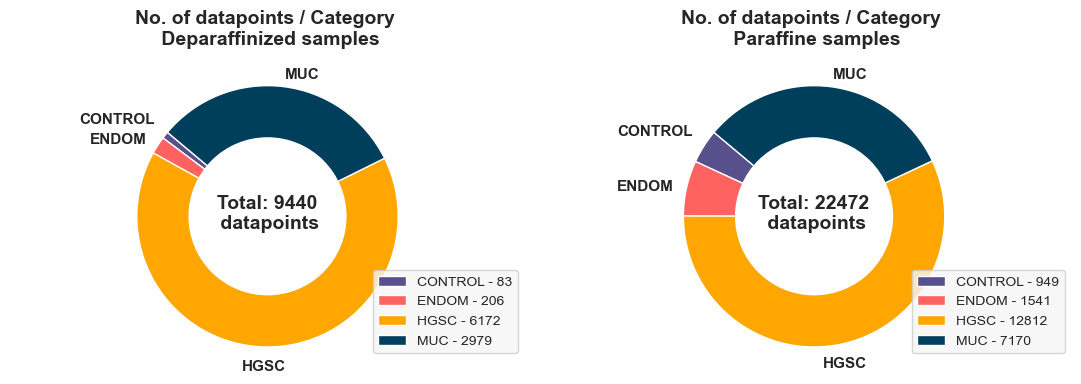

In [9]:
# Create colour palette
palette = ["#58508d","#ff6361","#ffa600", "#003f5c", "#00AAA0", "#bc5090", "#FADA5E", "#4B8BBE"]

# Set the Seaborn theme
sns.set_theme(palette=palette)
    
# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(11, 4))

# Plot for label_counts_DEP
create_subplot(axs[0], label_counts_DEP, 'No. of datapoints / Category \n Deparaffinized samples', 'datapoints')

# Plot for label_counts_PAR
create_subplot(axs[1], label_counts_PAR, 'No. of datapoints / Category \n Paraffine samples', 'datapoints')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

Above, it's evident that the **majority of samples** belong to the high-grade serous carcinoma (**HGSC**) category, followed by mucinous carcinoma (**MUC**) as the second most abundant category. However, in the control group and endometrial carcinoma (ENDOM), the number of data points is significantly lower compared to the other two groups. More importantly, it's **crucial to analyze the origin of data points** in these underrepresented groups by **examining the number of patients associated with each category**. Let's group the entries by category and patient code for further investigation.

In [10]:
label_counts_patient_PAR = (data_raw_PAR.groupby('Category')['Patient']
                           .nunique()
                           .reset_index(name='Count'))
                            
label_counts_patient_DEP = (data_raw_DEP.groupby('Category')['Patient']
                           .nunique()
                           .reset_index(name='Count'))

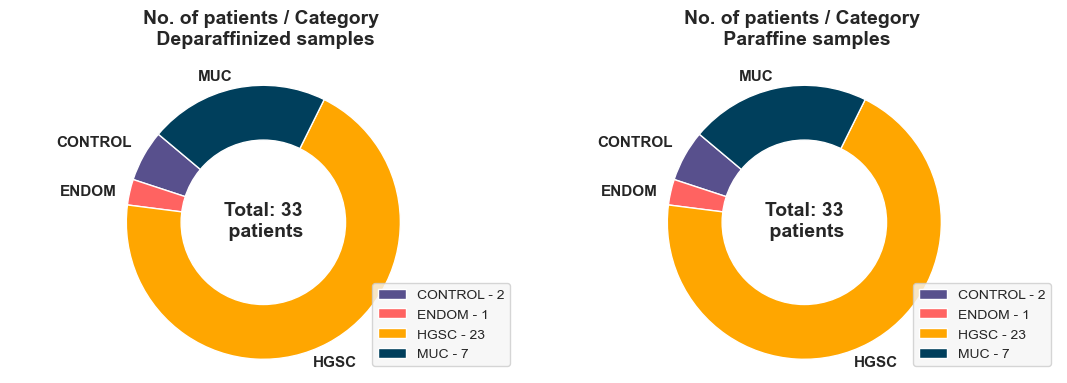

In [11]:
# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(11, 4))

# Plot for label_counts_DEP
create_subplot(axs[0], label_counts_patient_DEP, 'No. of patients / Category \n Deparaffinized samples', 'patients')

# Plot for label_counts_PAR
create_subplot(axs[1], label_counts_patient_PAR, 'No. of patients / Category \n Paraffine samples', 'patients')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

From the figures above, it's apparent that there are only two patients in the control group and one patient in the ENDOM group for both types of samples. This insight will be crucial for partitioning the data into training and test sets.

### 2. Dataset splitting

Based on the preceding analysis, it's clear that:

* The number of patients in the CONTROL and ENDOM sample groups is insufficient for a reliable training-test split. Consequently, **classification will exclusively focus on MUC and HGSC samples**.
<br>
* The right method for dividing the data into training and testing sets is through **patient-wise splitting**. This methodology ensures that **data from each patient is allocated exclusively to either the training or test set, thus preventing potential data leakage**. 

    <span style="color:gray">_(Similar problem was described in the following paper: "Training machine learning models on patient level data segregation is crucial in practical clinical applications", Oner et al.medRxiv 2020.04.23.20076406; doi: https://doi.org/10.1101/2020.04.23.20076406)_</span>


    For comparison, we will also generate a dataset where all data points are randomly assigned to either the training or test set, allowing us to **illustrate the impact of data leakage on model performance**.

We'll begin by excluding the data points associated with CONTROL and ENDOM samples.

In [12]:
# remove the datapoints related to CONTROL and ENDOM samples
data_raw_PAR = data_raw_PAR[~data_raw_PAR['Category'].isin(['CONTROL', 'ENDOM'])]
data_raw_DEP = data_raw_DEP[~data_raw_DEP['Category'].isin(['CONTROL', 'ENDOM'])]

#### 2A. Patient-level splitting ####

First, we need to ensure that all patient codes are of the same data type, regardless of whether they contain only numbers or a mix of numbers and letters.

In [13]:
# convert all patient codes to strings to ensure consistent data type
data_raw_PAR.loc[:,'Patient'] = data_raw_PAR['Patient'].astype('str')
data_raw_DEP.loc[:,'Patient'] = data_raw_DEP['Patient'].astype('str')

To effectively divide the data into training and test sets, we'll utilize **Group Shuffle Split**. This method enables random splitting of the data while **ensuring that all data points recorded for a single patient reside exclusively in either the training or test set**.

In [14]:
# initialize GroupShuffleSplit for splitting the data into training and test sets.
splitter = GroupShuffleSplit(test_size=0.20, n_splits=1, random_state = 0)

In [15]:
# split samples in paraffine
split = splitter.split(data_raw_PAR, groups=data_raw_PAR['Patient'])
train_inds, test_inds = next(split)

train_PAR_patient = data_raw_PAR.iloc[train_inds]
test_PAR_patient = data_raw_PAR.iloc[test_inds]

In [16]:
# split deparaffinized samples
split = splitter.split(data_raw_DEP, groups=data_raw_DEP['Patient'])
train_inds, test_inds = next(split)

train_DEP_patient = data_raw_DEP.iloc[train_inds]
test_DEP_patient = data_raw_DEP.iloc[test_inds]

Let's confirm that no patient samples are present in both the training and test sets.

In [17]:
# retrieve unique patient IDs from the training set and test set.
A = set(train_PAR_patient['Patient'].unique())
B = set(test_PAR_patient['Patient'].unique())

# find the intersection of unique patient IDs between the training set and test set.
A.intersection(B)

set()

We observe that the intersection of training and test set patient codes does indeed yield an empty set.

In [18]:
# export the datasets
train_PAR_patient.to_csv('../data/train_PAR_patient.csv')
test_PAR_patient.to_csv('../data/test_PAR_patient.csv')

train_DEP_patient.to_csv('../data/train_DEP_patient.csv')
test_DEP_patient.to_csv('../data/test_DEP_patient.csv')

#### 2B. Standard train-test splitting ####

To contrast with the properly split data mentioned earlier, let's examine a scenario where we directly apply the most standard train-test split to the dataset.

In [19]:
# split the datasets into training and test sets
train_PAR_entry, test_PAR_entry = train_test_split(data_raw_PAR, test_size=0.2, random_state=0)
train_DEP_entry, test_DEP_entry = train_test_split(data_raw_DEP, test_size=0.2, random_state=0)

In [20]:
# export the datasets
train_PAR_entry.to_csv('../data/train_PAR_entry.csv')
test_PAR_entry.to_csv('../data/test_PAR_entry.csv')

train_DEP_entry.to_csv('../data/train_DEP_entry.csv')
test_DEP_entry.to_csv('../data/test_DEP_entry.csv')

Later on, we'll revisit those datasets to assess the extent of overestimation in the model's performance when we neglect to split the data at the patient level.

### 3. Data exploration

In [21]:
data_raw.describe()

,Lipids,Unsaturated lipids,CH3 groups,CH2 groups,Ester groups,Unsaturated/saturated lipid ratio,Lipid saturation,Carbonyl/lipid ratio,Amide I,Lipid/protein ratio,...,Band 1450,Band 1390,Band 1240,Band 1080,Band 1310,Band 2850,Band 3060,Biomass_I,Biomass_II,Biomass_Total
count,31912.000000,31912.000000,31912.000000,31912.000000,31912.000000,31912.000000,31912.000000,31912.000000,31912.000000,31912.000000,...,31912.000000,31912.000000,31912.000000,31912.000000,31912.000000,31912.000000,31912.000000,31912.000000,31912.000000,31912.000000
mean,24.846343,-0.014731,2.290090,11.151939,-0.161978,-0.011964,4.183101,-0.018764,5.719310,6.723645,...,1.029627,0.427061,0.392735,0.629494,0.022107,4.030647,0.099232,39.066903,33.407301,72.474204
std,17.853234,0.008707,1.542136,8.254825,0.072436,0.134562,2.311403,0.940366,2.633888,152.665283,...,0.638488,0.158479,0.168214,0.440272,0.025501,2.986890,0.064941,16.260292,13.094158,27.207239
min,-0.106751,-0.187319,-0.037424,-0.009415,-0.559956,-20.574695,-55.888301,-9.467781,-0.535354,-11463.293854,...,-0.071033,-0.132053,-0.101492,-0.589192,-0.202773,-0.010721,-0.378584,-10.508358,-16.230971,-21.257606
25%,2.843458,-0.018647,0.516018,1.189789,-0.211130,-0.020296,2.545845,-0.046808,3.850963,0.408949,...,0.325684,0.324803,0.278651,0.428183,0.011896,0.305769,0.058491,29.841367,25.732793,55.898884
50%,30.561344,-0.014549,2.657546,13.817506,-0.164254,-0.005961,4.414173,-0.005975,5.889930,4.981391,...,1.164171,0.437147,0.408310,0.571713,0.025279,5.096267,0.096981,39.919484,34.279742,74.904316
75%,40.143874,-0.010121,3.510655,18.601356,-0.115527,-0.004846,5.615389,-0.004015,7.580392,7.330542,...,1.515115,0.523619,0.509545,0.734149,0.036505,6.567417,0.138741,50.743708,41.495205,89.928424
max,85.482173,0.004719,12.273891,29.254765,0.332083,3.663749,220.056029,164.366653,18.016197,13365.766108,...,4.780203,1.673367,1.327351,5.472854,0.215199,12.683807,0.738455,131.239033,114.385624,237.947558


We can already see that the data contains a lot of negative values. The values in the table are counts under a peak. Negative values should normally have no physical meaning (negative means that the baseline in the spectrum is above the peak -> very little or no counts observed). However in this situation I would argue that still it carries a valuable information about the shape of the spectrum. So for now I will keep these variables.

Let's have a look at the comparison of molecular composition between the paraffine and deparaffinized samples

<Axes: xlabel='Lipids', ylabel='Count'>

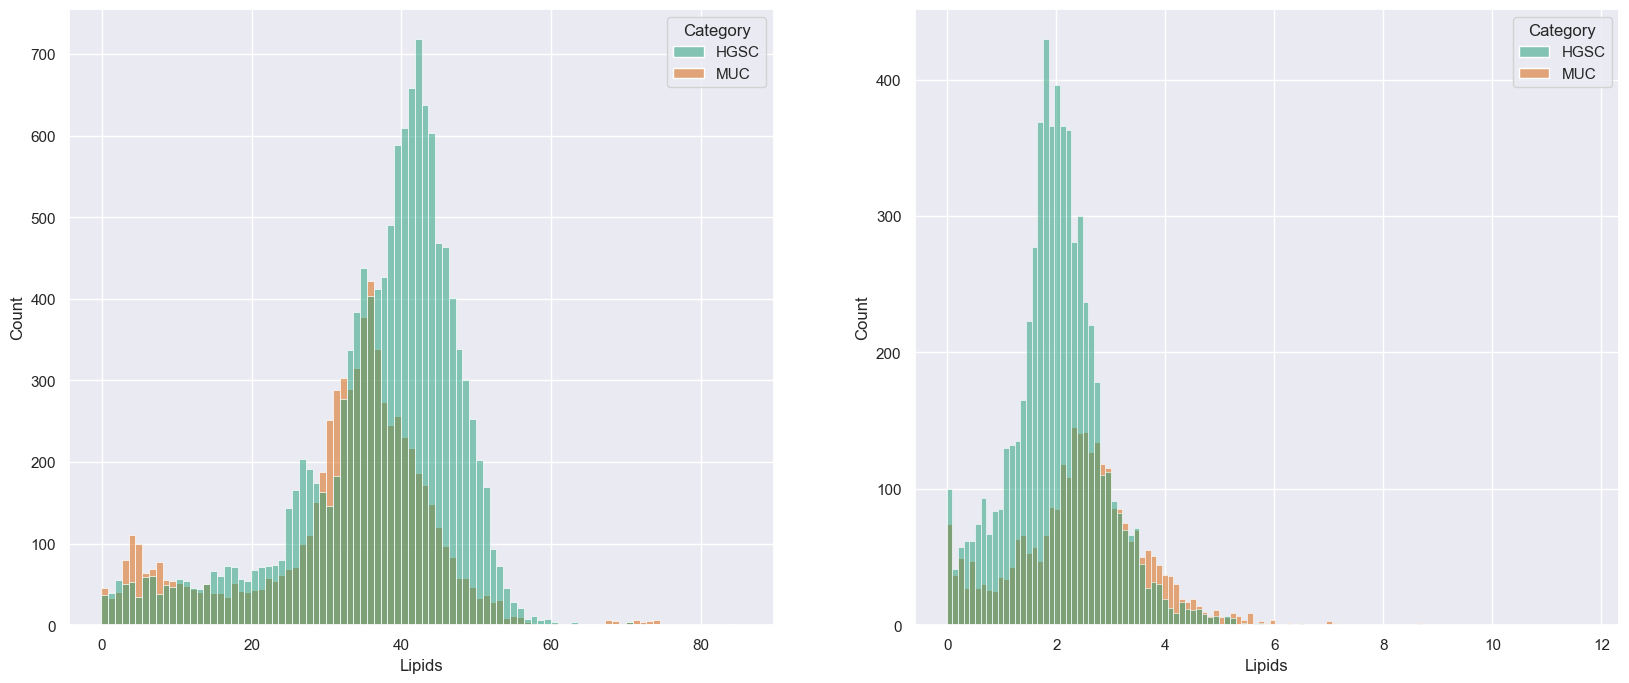

In [22]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
sns.histplot(data_raw_PAR, x='Lipids', hue='Category', ax=ax1, palette = 'Dark2')
sns.histplot(data_raw_DEP, x='Lipids', hue='Category', ax=ax2, palette = 'Dark2')

<Axes: xlabel='CH3 groups', ylabel='Count'>

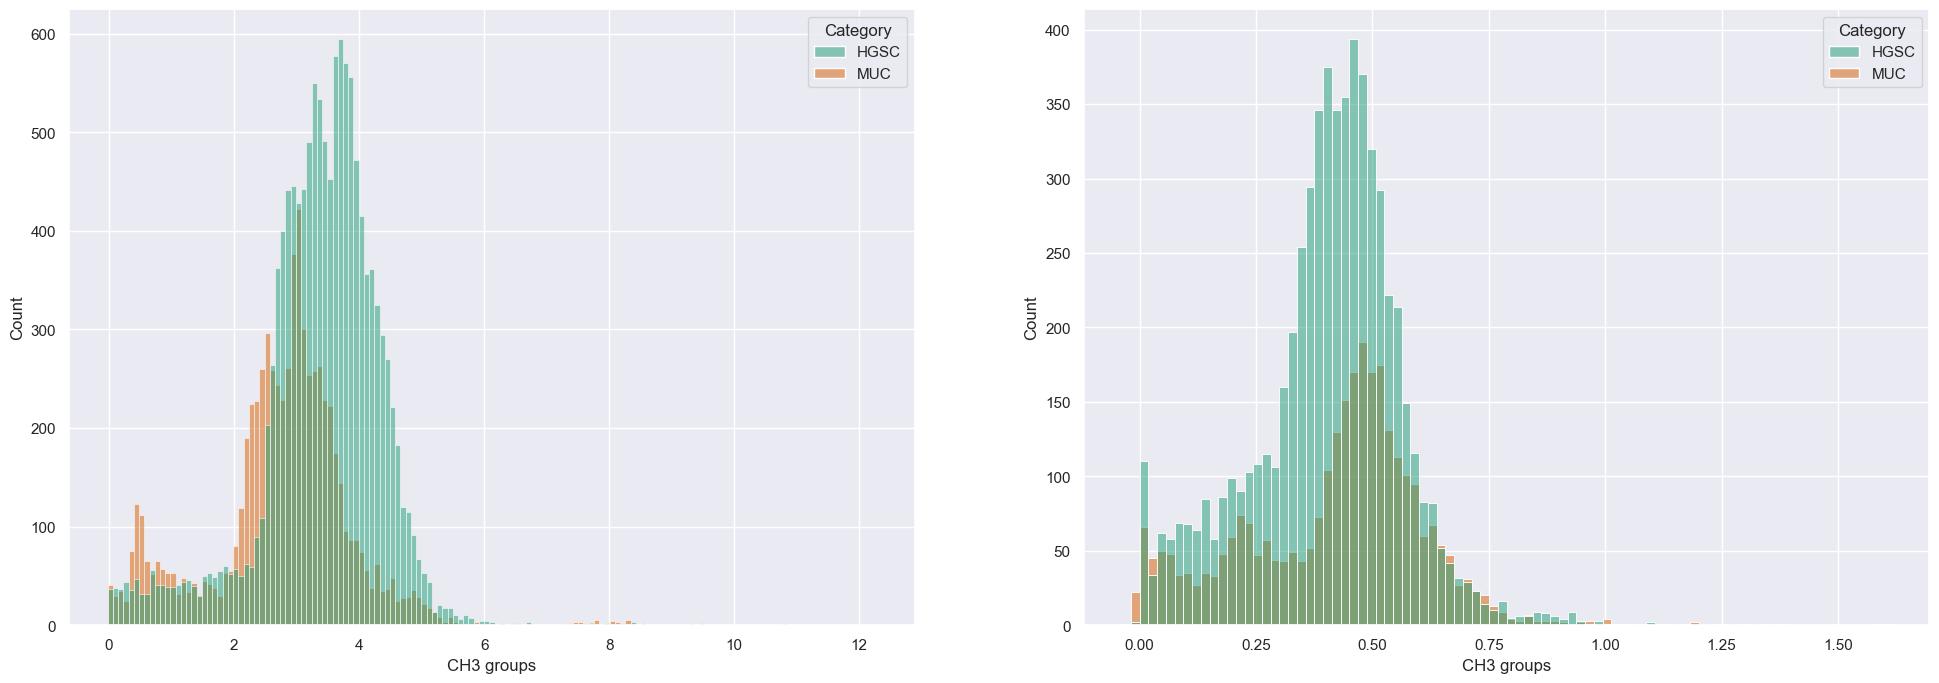

In [23]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(24,8))
sns.histplot(data_raw_PAR, x='CH3 groups', hue='Category', ax=ax1, palette = 'Dark2')
sns.histplot(data_raw_DEP, x='CH3 groups', hue='Category', ax=ax2, palette = 'Dark2')

<Axes: xlabel='Band 1080', ylabel='Count'>

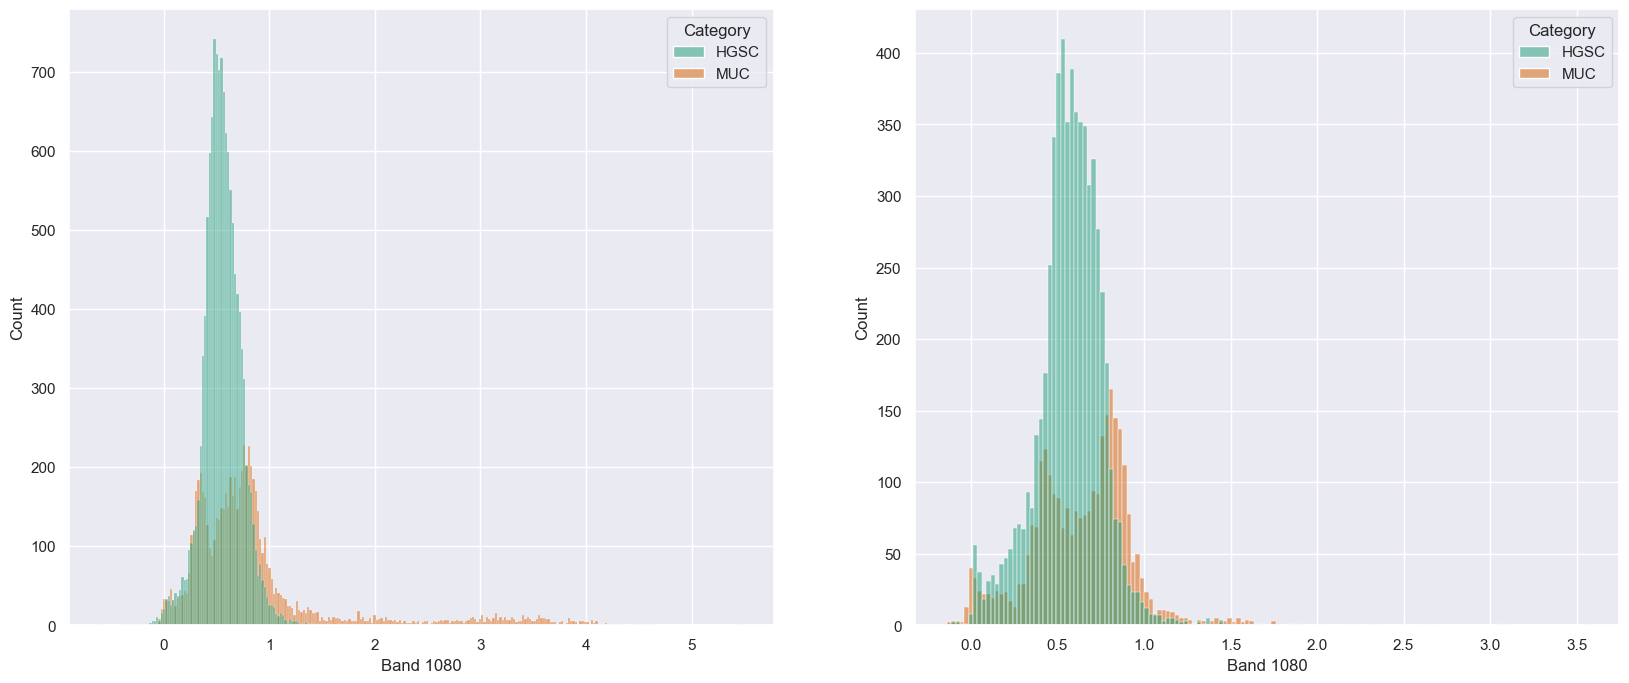

In [24]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
sns.histplot(data_raw_PAR, x='Band 1080', hue='Category', ax=ax1, palette = 'Dark2')
sns.histplot(data_raw_DEP, x='Band 1080', hue='Category', ax=ax2, palette = 'Dark2')

<Axes: xlabel='Alpha helix', ylabel='Count'>

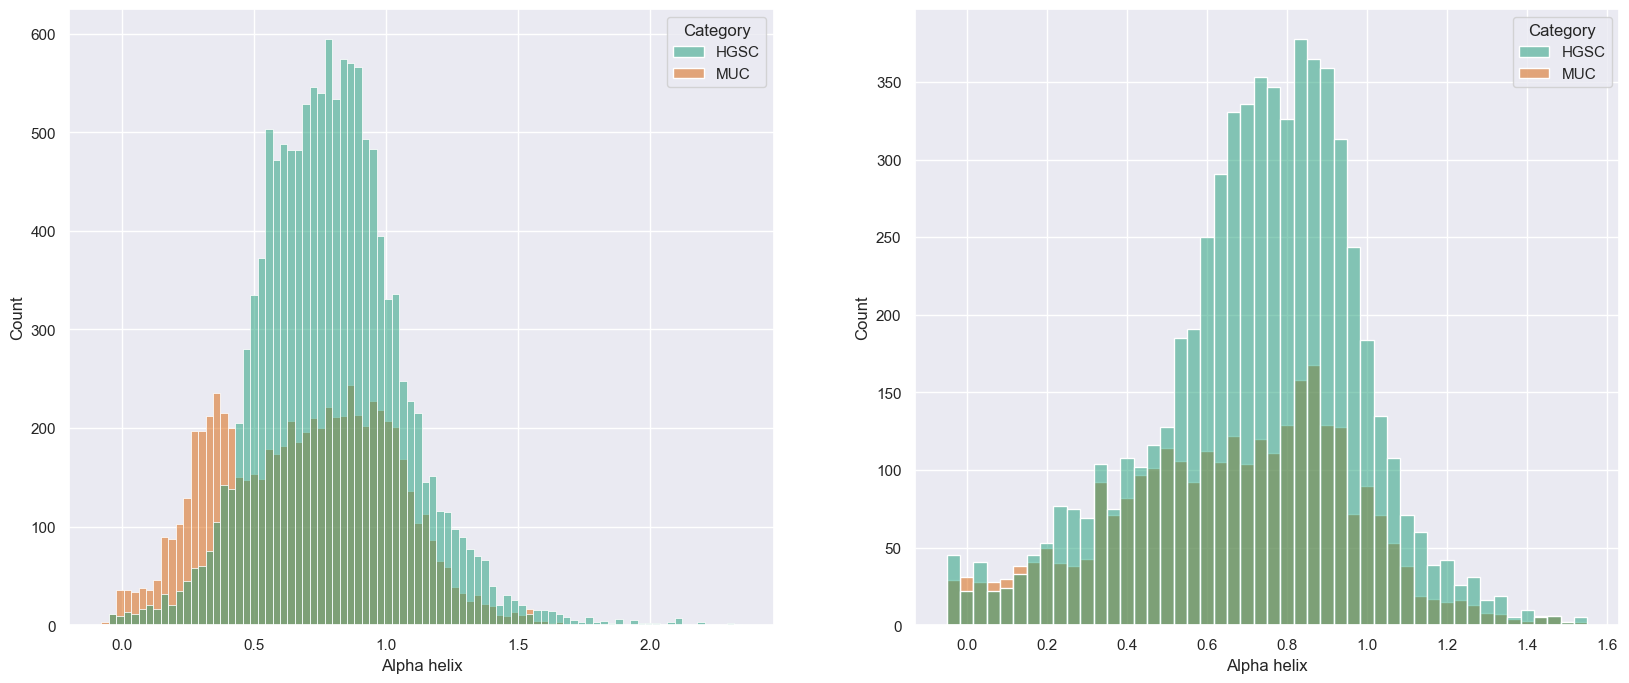

In [25]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
sns.histplot(data_raw_PAR, x='Alpha helix', hue='Category', ax=ax1, palette = 'Dark2')
sns.histplot(data_raw_DEP, x='Alpha helix', hue='Category', ax=ax2, palette = 'Dark2')

In all cases above ENDOM samples seem to be well separated from other types of tissue. It may be caused by the fact that the population of samples is relatively small. Alternatively, the ENDOM samples may have lower density and thus the sample of the same thicknes would absorb less.

Variation in the possible thickness and density of the tissues will be addressed by using ratio of counts rather than counts under peaks. 

To understand the data better bivariate analysis was used. To make the plot clearer only variables with significant amount of counts (well above zero) were used.

In [26]:
selected_columns = data_raw_PAR[['Category','Lipids', 'CH3 groups', 'CH2 groups','Alpha helix', 'Beta sheets','Band 1390',
       'Band 1240']].copy()

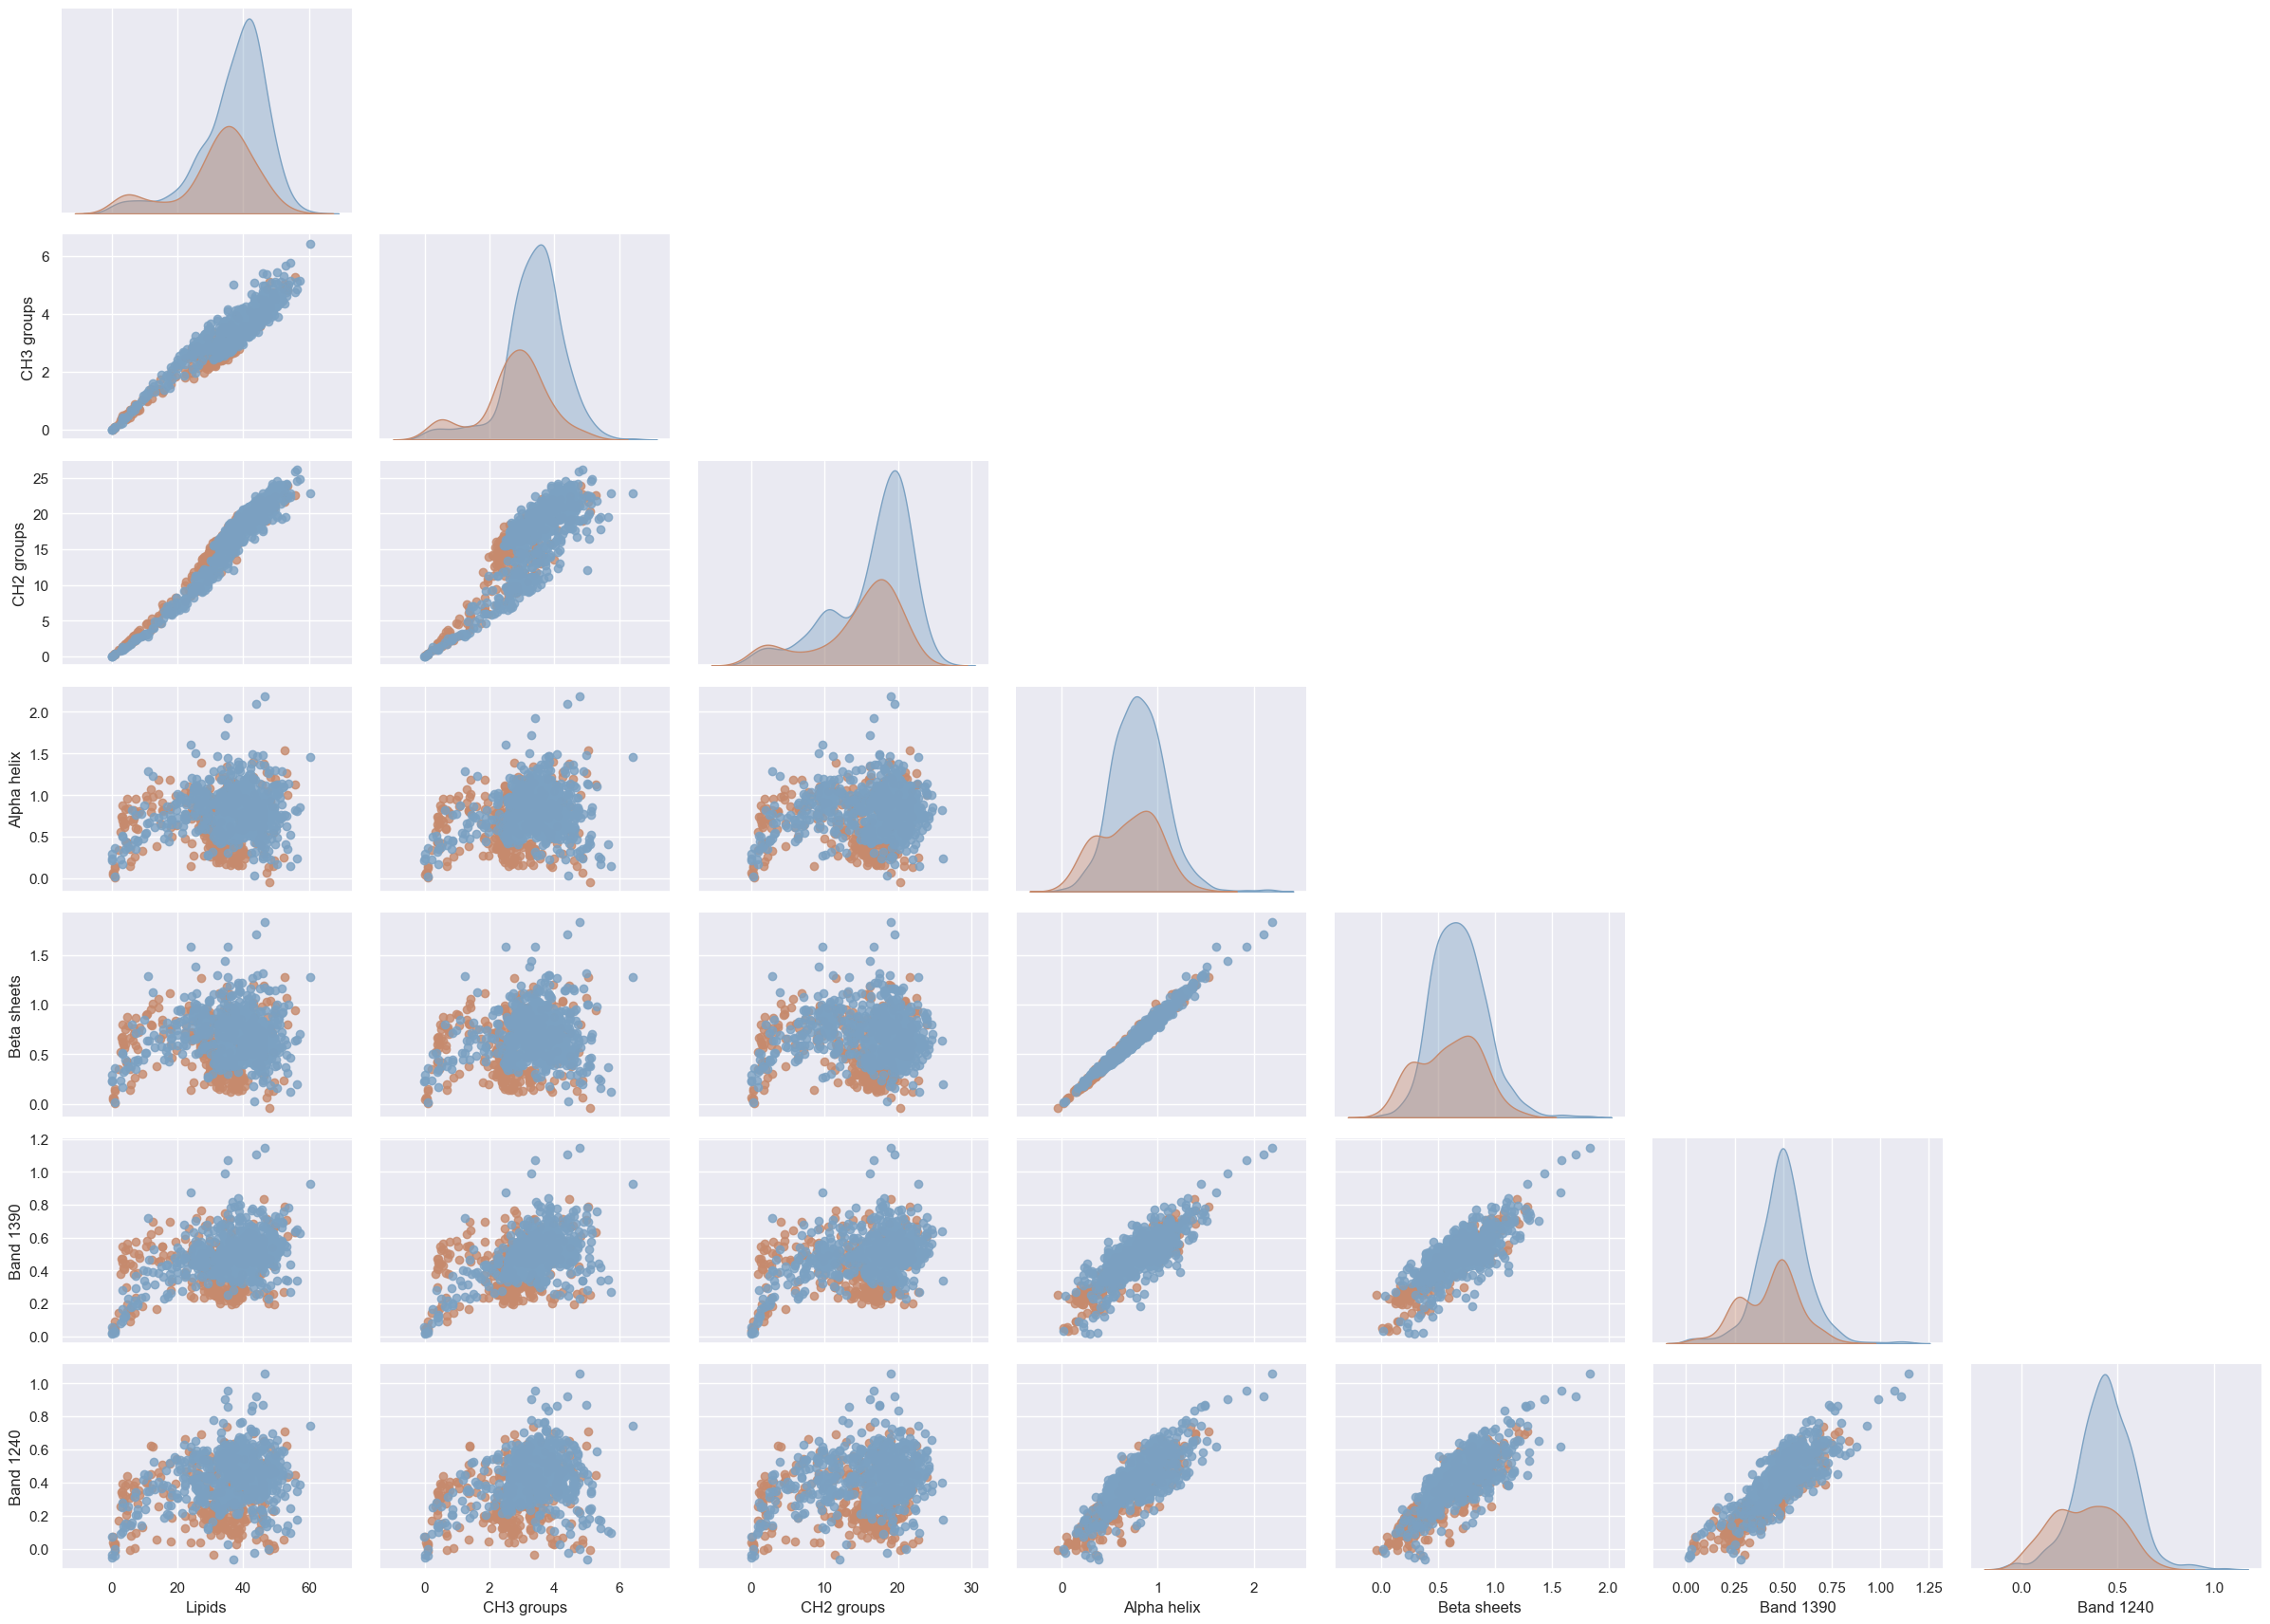

In [27]:
g = sns.PairGrid(selected_columns.sample(1000), hue='Category', palette = 'twilight_shifted_r', aspect=1.4, diag_sharey=False, corner=True)
g.map_lower(plt.scatter, alpha=0.8)
g.map_diag(sns.kdeplot, alpha=0.4, fill=True)

As we can see, in many of scatter plots above, data points representing different histological types group along lines with different slopes. This suggests that taking the ratios of those variables may be helpful in distinguishing between different sample types. This further supports the idea of using ratios of counts instead of counts themselves.

### Ratios calculation

For reason mentioned before, the data exploration will be continued after the original data are replaced with selected ratios.  Only meaningful ratios were selected.

In [28]:
def to_ratios(df):
    df['Biomass I/Biomass II'] = df['Biomass_I']/df['Biomass_II']
    df['Amide III/Amide I'] = df['Band 1310']/df['Amide I']
    df['1080/1240'] = df['Band 1080']/df['Band 1240']
    df['1450/1390'] = df['Band 1450']/df['Band 1390']
    df['1080/Amide I'] = df['Band 1080']/df['Amide I']
    df['10240/Amide I'] = df['Band 1240']/df['Amide I']
    df['(1450+1390)/Lipids'] = (df['Band 1450']+df['Band 1390'])/df['Lipids']
    df['1450/Lipids'] = df['Band 1450']/df['Lipids']
    df['1390/Lipids'] = df['Band 1390']/df['Lipids']
    df['Amide B/Amide I'] = df['Band 3060']/df['Amide I']
    df['Amide III/Amide B'] = df['Band 1310']/df['Band 3060']
    df['CH3/1450'] = df['CH3 groups']/df['Band 1450']
    df['2850/1450'] = df['Band 2850']/df['Band 1450']
    df.drop(['Lipids', 'Unsaturated lipids', 'CH3 groups', 'CH2 groups', 'Ester groups', 'Amide I','Alpha helix', 'Beta sheets', 'Beta turns',  'Band 1450', 'Band 1390', 'Band 1240', 'Band 1080', 'Band 1310', 'Band 2850', 'Band 3060', 'Biomass_I', 'Biomass_II', 'Biomass_Total'], axis=1, inplace=True)
    return df

In [29]:
ratios_raw = to_ratios(data_raw.copy())
ratios_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31912 entries, 0 to 31911
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Patient                            31912 non-null  object 
 1   Sample                             31912 non-null  object 
 2   Category                           31912 non-null  object 
 3   Unsaturated/saturated lipid ratio  31912 non-null  float64
 4   Lipid saturation                   31912 non-null  float64
 5   Carbonyl/lipid ratio               31912 non-null  float64
 6   Lipid/protein ratio                31912 non-null  float64
 7   Alpha helix/beta sheets            31912 non-null  float64
 8   Percentage of beta forms           31912 non-null  float64
 9   Biomass I/Biomass II               31912 non-null  float64
 10  Amide III/Amide I                  31912 non-null  float64
 11  1080/1240                          31912 non-null  flo

Again, let's split the data into separate datasets for samples in paraffine and deparaffinized. We need to do that before outliers removal because datasets may have different range for some variables

In [30]:
ratios_raw_DEP = ratios_raw[data_raw.Category.str.contains('dep')]
ratios_raw_PAR = ratios_raw[data_raw.Category.str.contains('par')]

Above it can be seen that conversion to ratios did not cause any problems (eg. due to dividing by 0 or by very small values)

In [31]:
ratios_raw_PAR.describe()

,Unsaturated/saturated lipid ratio,Lipid saturation,Carbonyl/lipid ratio,Lipid/protein ratio,Alpha helix/beta sheets,Percentage of beta forms,Biomass I/Biomass II,Amide III/Amide I,1080/1240,1450/1390,1080/Amide I,10240/Amide I,(1450+1390)/Lipids,1450/Lipids,1390/Lipids,Amide B/Amide I,Amide III/Amide B,CH3/1450,2850/1450
count,22472.000000,22472.000000,22472.000000,22472.000000,22472.000000,22472.000000,22472.000000,22472.000000,22472.000000,22472.000000,22472.000000,22472.000000,22472.000000,22472.000000,22472.000000,22472.000000,22472.000000,22472.000000,22472.000000
mean,-0.007485,4.987316,0.001763,9.399186,1.169709,61.916129,1.418299,0.006693,1.861567,3.058057,0.143904,0.076792,0.080226,0.052609,0.027617,0.012704,0.218880,2.248599,4.120006
std,0.148398,2.230391,1.116259,181.861303,0.768696,2.328095,5.043855,0.083257,10.589110,1.122843,0.737446,0.200946,2.941159,1.351760,1.590092,0.314872,24.511016,0.550504,1.170539
min,-20.574695,-55.888301,-9.467781,-11463.293854,-113.118471,15.902753,-59.039614,-5.224654,-872.406391,-30.061938,-19.822383,-8.179058,-44.278926,-20.511607,-23.767319,-20.950428,-3122.761291,-12.223057,-19.106155
25%,-0.006207,4.170605,-0.006461,4.724008,1.124370,60.573871,1.122723,0.003575,1.212192,2.496458,0.084829,0.061440,0.045340,0.034116,0.010731,0.012794,0.183831,2.077816,3.605615
50%,-0.005221,5.243412,-0.004722,6.282095,1.188111,61.508897,1.398830,0.005448,1.379911,2.917935,0.098933,0.069187,0.050398,0.037439,0.013016,0.015146,0.344975,2.319835,4.390126
75%,-0.004595,5.848654,-0.003651,8.421250,1.230738,62.986462,1.596305,0.007283,1.697071,3.431654,0.138253,0.079443,0.061174,0.044955,0.016583,0.017897,0.477494,2.514087,4.865102
max,2.959302,220.056029,164.366653,13365.766108,5.307617,192.002241,713.158158,4.642924,312.450422,37.452627,66.985405,22.435881,425.130942,195.179622,229.951321,30.053824,681.924812,26.354707,43.991245


In [32]:
ratios_raw_DEP.describe()

,Unsaturated/saturated lipid ratio,Lipid saturation,Carbonyl/lipid ratio,Lipid/protein ratio,Alpha helix/beta sheets,Percentage of beta forms,Biomass I/Biomass II,Amide III/Amide I,1080/1240,1450/1390,1080/Amide I,10240/Amide I,(1450+1390)/Lipids,1450/Lipids,1390/Lipids,Amide B/Amide I,Amide III/Amide B,CH3/1450,2850/1450
count,9440.000000,9440.000000,9440.000000,9440.000000,9440.000000,9440.000000,9440.000000,9440.000000,9440.000000,9440.000000,9440.000000,9440.000000,9440.000000,9440.000000,9440.000000,9440.000000,9440.000000,9440.000000,9440.000000
mean,-0.022626,2.268662,-0.067627,0.354495,1.102184,62.016446,0.838625,0.002548,1.578872,0.697831,0.104367,0.069160,0.293058,0.118404,0.174654,0.020679,0.082310,1.865952,1.090197
std,0.092880,1.006894,0.140703,0.242251,0.117503,22.428095,0.504648,0.021417,11.182846,0.360551,0.151256,0.095727,0.404981,0.155207,0.260146,0.012957,4.750508,8.663385,10.524907
min,-2.074336,-21.326547,-7.076297,-5.836347,-4.372162,-399.354510,-10.213844,-1.765269,-306.487506,-15.730013,-7.942428,-2.353385,-17.186192,-8.227910,-11.100399,-0.471952,-382.472621,-79.702397,-46.356688
25%,-0.026026,1.940067,-0.088612,0.282370,1.027941,60.450729,0.760768,0.000928,1.225095,0.616512,0.078040,0.059246,0.242302,0.096227,0.142535,0.018875,0.047196,1.458915,0.654899
50%,-0.023417,2.129348,-0.072063,0.318273,1.111483,61.455103,0.893581,0.003286,1.370537,0.686345,0.091204,0.065883,0.287857,0.113270,0.170892,0.020351,0.164116,1.772968,0.804972
75%,-0.020808,2.487836,-0.056523,0.380558,1.177752,63.087558,0.972607,0.004855,1.579338,0.766894,0.111945,0.072495,0.327925,0.133183,0.194848,0.022812,0.244176,1.936179,1.083317
max,3.663749,52.807238,4.013944,11.318112,3.623075,2130.251724,20.226378,0.648670,647.511123,13.599328,2.917221,8.051948,9.709421,3.261416,6.448005,0.449613,90.903622,617.696146,936.580640


To detect outliers IQR (interquartile range) rule was applied. The outliers were not removed because having 19 variables, each having outliers, could lead to deleting a significant portion of the data. I chose to winsorize the outliers. This approach was selected because it's very unlikely that the data would be erroneous (there is no human factor because the spectra were fitted with well established algorithm and problems with background removal would very likely affect the whole spectrum) so for this reason I would rather believe that the ratios are truly very big or very small and thus the approach which would keep partly this information is to Winsorize them to the closest inlier.

In [33]:
def outliers_lim(df, n=1.5):
    """
    finds limits for inliners with IQR method. 
    you can set the scaling factor n to some other value, e.g. 2 or 3
    """
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    lower_lim = Q1 - n * IQR
    upper_lim = Q3 + n * IQR
    return lower_lim, upper_lim

In [48]:
import scipy.stats as stats

def winsorize_outliers(df, limits):
    """
    winsorizes the given dataset.
    takes lower and upper limit as a tuple (lower, upper)
    """
    low, upp = limits
    cols = df.select_dtypes(include=np.number).columns.tolist()
    for col in cols:
        # find which percentile are the limits obtained with IQR...
        percentile_low = percentileofscore(df[col], low[col])/100
        percentile_upp = 1 - percentileofscore(df[col], upp[col])/100
        # ...and winsorize the data accordingly
        df[col] = stats.mstats.winsorize(df[col], limits = [percentile_low, percentile_upp])
    return df

### Data exploration 

#### of ratios of values in selected columns

In [ ]:
ratios_win_PAR = winsorize_outliers(ratios_raw_PAR.select_dtypes(include='number').copy(), outliers_lim(ratios_raw_PAR.select_dtypes(include='number')))
ratios_win_PAR.describe()

In [ ]:
ratios_win_DEP = winsorize_outliers(ratios_raw_DEP.select_dtypes(include='number').copy(), outliers_lim(ratios_raw_DEP.select_dtypes(include='number')))
ratios_win_DEP.describe()

Let's look at the distribution of values for both embedded in paraffine and deparaffinized samples.

In [59]:
ratios_raw.columns

Index(['Patient', 'Sample', 'Category', 'Unsaturated/saturated lipid ratio',
       'Lipid saturation', 'Carbonyl/lipid ratio', 'Lipid/protein ratio',
       'Alpha helix/beta sheets', 'Percentage of beta forms',
       'Biomass I/Biomass II', 'Amide III/Amide I', '1080/1240', '1450/1390',
       '1080/Amide I', '10240/Amide I', '(1450+1390)/Lipids', '1450/Lipids',
       '1390/Lipids', 'Amide B/Amide I', 'Amide III/Amide B', 'CH3/1450',
       '2850/1450'],
      dtype='object')

In [ ]:
n=0
for col in ratios_raw.select_dtypes(include=[np.number]):
    print(col)
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
    sns.histplot(ratios_win_PAR, x=col, hue='Category', ax=ax1, palette = 'Dark2')
    sns.histplot(ratios_win_DEP, x=col, hue='Category', ax=ax2, palette = 'Dark2')
    plt.show()

    

From the histograms above we can see, that Lipid saturation is a promising discriminant between HGSC and MUC in deparaffinized samples. For the samples in paraffine 1080/1240 cm^-1, 1240/Amide I and CH3/1450 bands seems to separate the samples quite well. Amide III/Amide B ratio looks promising for both types of samples.

Looking at boxplots will help us understand better the differences between the samples embedded in paraffin and the deparaffinized samples.

In [ ]:
df = pd.concat([ratios_win_PAR, ratios_win_DEP], axis=0)

In [ ]:
sns.boxplot(data=df, x='Lipid/protein ratio', y='Category', palette = 'deep')

It can be noted that deparaffinization influenced lipid saturation significantly. It may be caused by washing out of lipids by the solvent used.

In [ ]:
sns.boxplot(data=df, x='Lipid saturation', y='Category', palette = 'deep')

Especially we can see a change in the saturation of lipids (CH2 vibrational band / CH3 vibrational band) which may suggest more efficient washing out of CH2 groups.

In [ ]:
sns.boxplot(data=df, x='Amide III/Amide I', y='Category', palette = 'deep')

We can also observe that the ratio between Amide III and Amide I did not lower significantly after deparaffinization, and the trends observed for the samples in paraffine are maintained.

Now the data is ready for model building

#### Export data

Now the data is ready for the next step: model building

In [ ]:
ratios_win_PAR.to_csv('data/ratios_PAR.csv')
ratios_win_DEP.to_csv('data/ratios_DEP.csv')